[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AustinHouston/ML_workflow_talk/blob/main/TrainUNet.ipynb)

Install AtomAI:

In [ ]:
import os
!pip install ipympl

print('installing pyTEMlib')
!pip install pyTEMlib

print('installing atomai')
!pip install git+https://github.com/pycroscopy/atomai

print('installing DataGenSTEM')
!git clone https://github.com/ahoust17/DataGenSTEM.git

print('installing the data')
if not os.path.exists('./ML_workflow_talk'):
    !git clone https://github.com/AustinHouston/ML_workflow_talk.git

restart kernel (session) then run the following

In [1]:
import matplotlib.pylab as plt
import numpy as np
import os
import sys

import pyTEMlib.file_tools      
import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

import atomai as aoi

sys.path.append('./DataGenSTEM/DataGenSTEM')
import data_generator as dg

if 'google.colab' in sys.modules:
    from  google.colab import drive 
    from google.colab import output
    output.enable_custom_widget_manager()
%matplotlib widget

You don't have igor2 installed.     If you wish to open igor files, you will need to install it     (pip install igor2) before attempting.
You don't have gwyfile installed.     If you wish to open .gwy files, you will need to      install it (pip install gwyfile) before attempting.
Symmetry functions of spglib enabled


ModuleNotFoundError: No module named 'atomai'

Imports:

## Semantic segmentation

Download training/test data:

In [ ]:
if 'google.colab' in sys.modules:
    drive.mount("/content/drive")
    if not os.path.exists('./training_data.npy'):
        !gdown --id 1qAM5nEzIROLeIvolxkrIf1vgIZX0Odxl -O training_data.npy

In [5]:
# Load train/test data (this is a simple dataset generated just from a single image)
dataset = np.load('./training_data.npy')
images = dataset['X_train']
labels = dataset['y_train']
images_test = dataset['X_test']
labels_test = dataset['y_test']


print(images.shape, labels.shape)
print(images_test.shape, labels_test.shape)


(80, 256, 256) (80, 256, 256)
(20, 256, 256) (20, 256, 256)


In [ ]:
if not os.path.exists('./STO_image_stack.emd'):
    !wget  https://github.com/AustinHouston/ML_workflow_talk/raw/main/example_data/STO_image_stack.emd
        
dset = ft.open_file('STO_image_stack.emd')
image_stack = dset['Channel_000']

In [ ]:
# nice built-in plotting
view = image_stack.plot()

In [ ]:

image_stack.x

In [ ]:
# normalization
image = np.mean(image_stack, axis=0)

image -= image.min()
image /= image.max()

expdata = dg.shotgun_crop(image, crop_size=512, n_crops=5)

pixel_size = image_stack.x[1] * 10 # nm -> Ang
print('Pixel size:', pixel_size, 'Angstrom/pixel')

Let's plot some of the training data:

NameError: name 'images' is not defined

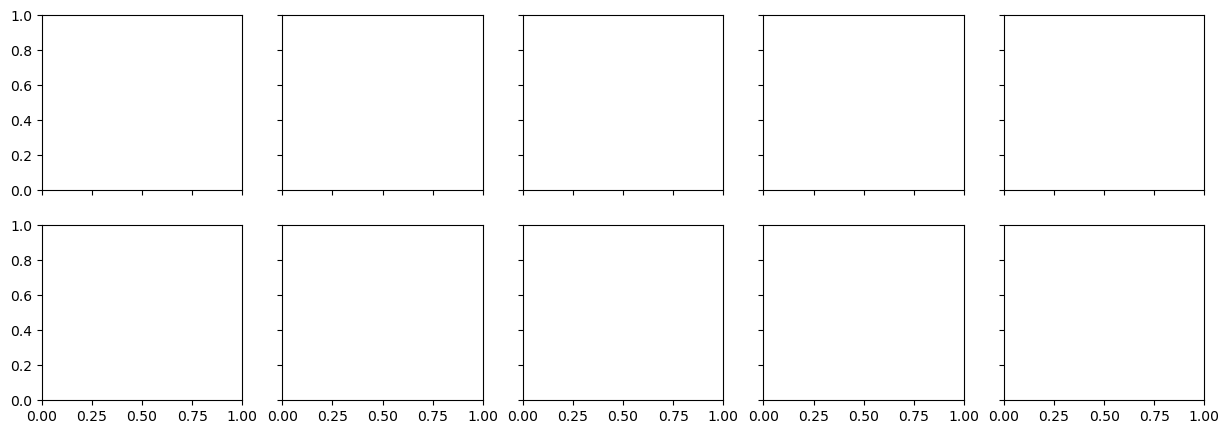

In [6]:
n = 5 # number of images to plot

fig, axs = plt.subplots(2, n, figsize=(15, 5), sharex=True, sharey=True)

for i in range(n):
    axs[0, i].imshow(images[i,0], cmap='gray')
    axs[0, i].axis('off')
    axs[1, i].imshow(labels[i], cmap='jet')
    axs[1, i].axis('off')
fig.tight_layout()

(Here the accuracy is calculated as [Intersection over Union](https://en.wikipedia.org/wiki/Jaccard_index) (IoU) score, which is the area of overlap between the predicted segmentation and the ground truth divided by the area of union between them)

/Users/austin/miniconda3/envs/atomai_env/lib/python3.12/site-packages/atomai/utils/preproc.py:54: UserWarning: Adding a channel dimension of 1 to training images
  warnings.warn(
/Users/austin/miniconda3/envs/atomai_env/lib/python3.12/site-packages/atomai/utils/preproc.py:59: UserWarning: Adding a channel dimension of 1 to test images
  warnings.warn(


Epoch 1/30 ... Training loss: 1.7513 ... Test loss: 1.5507 ... Train Accuracy: 0.2147 ... Test Accuracy: 0.1906 ... GPU memory usage: N/A / N/A
Epoch 30/30 ... Training loss: 0.7091 ... Test loss: 0.8796 ... Train Accuracy: 0.7952 ... Test Accuracy: 0.4873 ... GPU memory usage: N/A / N/A
Model (final state) evaluation loss: 0.9188
Model (final state) accuracy: 0.4588
Performing stochastic weight averaging...
Model (final state) evaluation loss: 1.4681
Model (final state) accuracy: 0.1891
Plotting training history


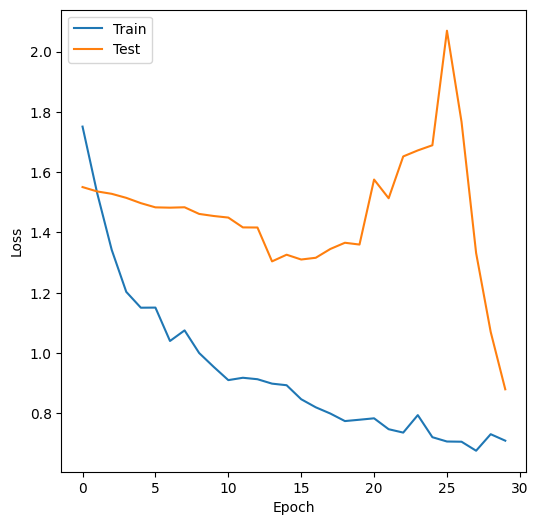

In [8]:
model = aoi.models.Segmentor(nb_classes=3)

# try this first:
# model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=1)

# Step 2
# model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=4)

# Step 3
# model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=4, lr_scheduler=[0.1])

# Step 4
# model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=4, lr_scheduler=[0.001])

# Step 5
model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=4, lr_scheduler=[0.001])
model.fit(images, labels, images_test, labels_test, training_cycles=300, compute_accuracy=True, swa=True, batch_size=4, lr_scheduler=[0.0001])

In [ ]:
nn_output, coordinates = model.predict(expdata)


Batch 1/1
1 image was decoded in approximately 0.2056 seconds


Plot raw prediction:

In [ ]:
fig, ax = plt.subplots(len(expdata),2, figsize=(4,20), sharex=True, sharey=True)

for i in range(len(expdata)):
  ax[i,0].imshow(expdata[i], cmap='gray', origin="lower")
  ax[i,1].imshow(nn_output[i].squeeze(), origin="lower")
for a in ax.ravel():
  a.axis('off')
fig.tight_layout()

Plot atomic coordinates:

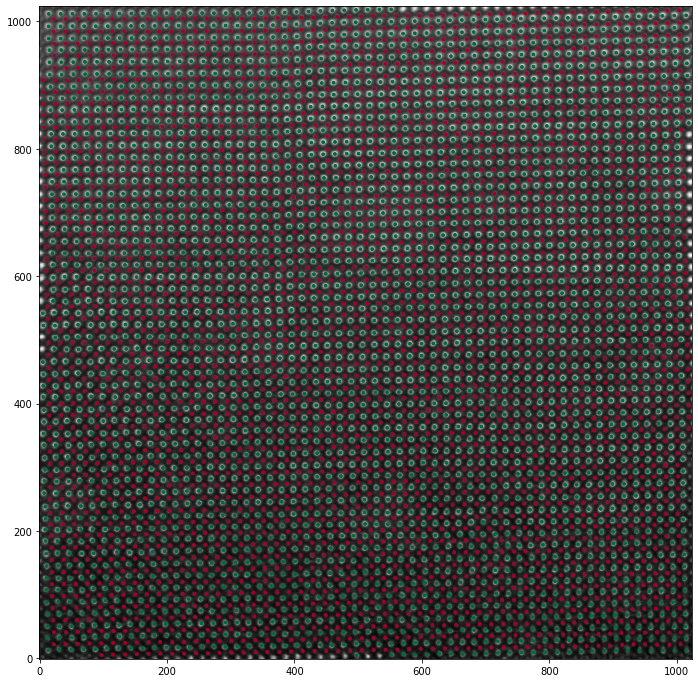

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

### Let's see how noisy we can make the image...

In [ ]:
noise = np.random.normal(0, 0.1, expdata.shape)
noisy_data = expdata + noise

fig, ax = plt.subplots(1, 1)
ax.imshow(noisy_data, cmap='gray')


In [ ]:
nn_output, coordinates = model.predict(noisy_data)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 12))
ax1.imshow(expdata, cmap='gray', origin="lower")
ax2.imshow(nn_output.squeeze(), origin="lower")

In [ ]:
aoi.utils.plot_coord(expdata, coordinates[0], fsize=12)

### AtomAI:
M. Ziatdinov, A. Ghosh, C. Y. Wong, and S. V. Kalinin,

“AtomAI framework for deep learning analysis of image and spectroscopy data in electron and scanning probe microscopy,”

Nature Machine Intelligence 2022 4:12, vol. 4, no. 12, pp. 1101–1112, Dec. 2022, doi: 10.1038/s42256-022-00555-8.